In [3]:
import pickle
import sys
from zoneinfo import ZoneInfo
sys.path.append("../")

from dotenv import load_dotenv
load_dotenv()
import geopandas as gpd
import importlib
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import lightning.pytorch as pl
import rasterio as rio
from rasterio.plot import show
import seaborn as sns
import shapely
import statsmodels.api as sm
from torch.utils.data import DataLoader

from openbustools import plotting, spatial, standardfeeds
from openbustools.traveltime import data_loader, model_utils
from openbustools.drivecycle import trajectory
from openbustools.drivecycle.physics import conditions, energy, vehicle

import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [4]:
importlib.reload(trajectory)
importlib.reload(energy)
importlib.reload(standardfeeds)
importlib.reload(vehicle)
importlib.reload(spatial)

all_phone_intensities = []
all_realtime_intensities = []

# List of phone trajectories available that have matching realtime data
phone_trajectory_folders = [x for x in Path("..","data","kcm_sensor","match_realtime").glob("*") if x.is_dir()]

# Build trajectory for each phone recording
for phone_trajectory_folder in phone_trajectory_folders[:2]:
    # Load phone data
    metadata_phone, data_phone = standardfeeds.combine_phone_sensors(phone_trajectory_folder, "America/Los_Angeles")
    data_phone.loc[data_phone['speed']<0, 'speed'] = np.nan
    data_phone.loc[data_phone['bearing']<0, 'bearing'] = np.nan
    data_phone = data_phone.bfill()
    # Create trajectory
    phone_traj = trajectory.Trajectory(
        point_attr={
            "lon": data_phone.longitude.to_numpy(),
            "lat": data_phone.latitude.to_numpy(),
            "measured_elev_m": data_phone.altitudeAboveMeanSeaLevel.to_numpy(),
            "measured_speed_m_s": data_phone.speed.to_numpy(),
            "measured_bear_d": data_phone.bearing.to_numpy(),
            "measured_accel_m_s2": np.diff(data_phone.speed.to_numpy(), prepend=0),
            "measured_theta_d": data_phone.pitch.to_numpy() - np.mean(data_phone.pitch.to_numpy()),
            "cumul_time_s": data_phone.cumul_time_s.to_numpy(),
        },
        traj_attr=metadata_phone,
        coord_ref_center=[386910, 69022],
        epsg=32148,
        apply_filter=True
    )
    # Create drivecycle
    phone_cycle = phone_traj.to_momentary_drivecycle()
    energy_model = energy.EnergyModel(vehicle.TransitBus(), conditions.AmbientConditions())
    phone_cycle_energy_df = energy_model.getEnergyDataFrame(phone_cycle)
    all_phone_intensities.append(energy_model.calcIntensity(phone_cycle)*1.6)


    # # Load corresponding realtime data
    # data_realtime = pd.read_pickle(Path("..", "data", "kcm_sensor_realtime", f"{phone_traj.traj_attr['t_day']}.pkl"))
    # # Pull the phone trajectory
    # data_realtime = data_realtime[data_realtime['vehicleid'].astype(int).astype(str) == phone_traj.traj_attr['veh_id']]
    # data_realtime = data_realtime[data_realtime['locationtime'].astype(int) >= phone_traj.traj_attr['start_epoch']]
    # data_realtime = data_realtime[data_realtime['locationtime'].astype(int) <= phone_traj.traj_attr['end_epoch']]
    # # Create trajectory
    # realtime_traj = trajectory.Trajectory(
    #     point_attr={
    #         "lon": data_realtime.lon.to_numpy(),
    #         "lat": data_realtime.lat.to_numpy(),
    #         "cumul_time_s": (data_realtime.locationtime - data_realtime.locationtime.min()).to_numpy(),
    #     },
    #     traj_attr=metadata_phone,
    #     coord_ref_center=[386910, 69022],
    #     epsg=32148,
    #     dem_file=Path("..", "data", "kcm_spatial","usgs10m_dem_32148.tif"),
    #     apply_filter=False
    # )
    # # Create drivecycle
    # realtime_cycle = realtime_traj.to_averaged_drivecycle()
    # energy_model = energy.EnergyModel(vehicle.TransitBus(), conditions.AmbientConditions())
    # realtime_cycle_energy_df = energy_model.getEnergyDataFrame(realtime_cycle)
    # all_realtime_intensities.append(energy_model.calcIntensity(realtime_cycle)*1.6)

In [89]:
# State is x, y, vx, vy (tt?)
# Measurement is x, y
# vx, vy depend on the time step
# What if dt is just a dummy variable? Assume constant v in transition; see actual

def makeKF(dt=1):
    kf = KalmanFilter(dim_x=4, dim_z=2)
    kf.x = np.array([0., 0, 0, 0]) # Initial state
    kf.P = np.diag([1., 1, 1, 1]) # State uncertainty
    kf.Q = np.diag([.1, .1, .1, .1]) # Process uncertainty
    kf.F = np.array([[1., 0, dt, 0],
                     [0., 1, 0, dt],
                     [0., 0, 1, 0],
                     [0., 0, 0, 1]]) # State transition
    kf.R = np.diag([.1, .1]) # Measurement uncertainty
    kf.H = np.array([[1., 0, 0, 0],
                     [0., 1, 0, 0]]) # Measurement transition
    return kf

labelx = np.diff(phone_traj.gdf[['x']].to_numpy().flatten())
labely = np.diff(phone_traj.gdf[['y']].to_numpy().flatten())
z = phone_traj.gdf[['x','y']].to_numpy()

xs = []
ps = []
kf = makeKF()

for i in range(z.shape[0]):
    kf.predict()
    xs.append(kf.x)
    ps.append(kf.P)
    kf.update(np.array([1., 1]))

[0.46131343 0.46131343 0.2947123  0.2947123 ]


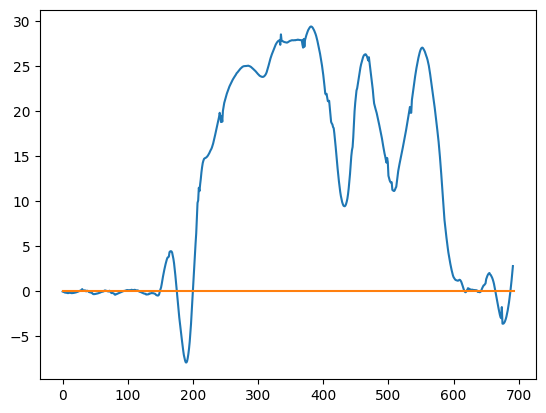

In [90]:
warmup = 30
plt.plot(labelx[warmup:])
plt.plot(np.array(xs)[warmup:,2])

variance = np.diagonal(np.array(ps), axis1=1, axis2=2)
print(variance[-1])

[0.46131343 0.46131343 0.2947123  0.2947123 ]


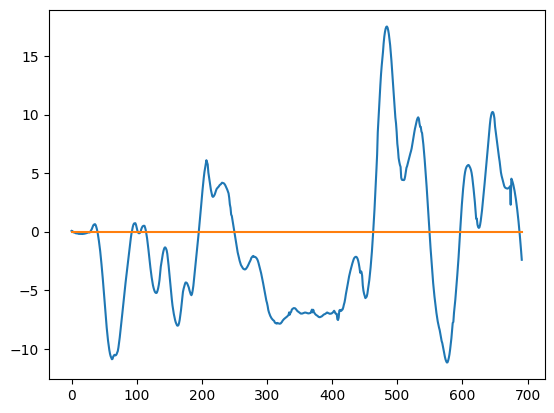

In [91]:
warmup = 30
plt.plot(labely[warmup:])
plt.plot(np.array(xs)[warmup:,3])

variance = np.diagonal(np.array(ps), axis1=1, axis2=2)
print(variance[-1])

In [25]:
def makeKF(dt):
    kf = KalmanFilter(dim_x=6, dim_z=2)
    kf.x = np.array([5000, 5000, 0., 0., 0., 0.]) # Initial state
    kf.P = np.diag([21, 21, 3, 3, 1, 1]) # State uncertainty
    kf.Q = np.diag([1, 1, .1, .1, .01, .01]) # Process uncertainty
    kf.R = np.diag([25., 25]) # Measurement uncertainty
    kf.F = np.array([[1., 0, dt, 0, .5*dt**2, 0],
                     [0., 1, 0, dt, 0, .5*dt**2],
                     [0., 0, 1, 0, dt, 0],
                     [0., 0, 0, 1, 0, dt],
                     [0., 0, 0, 0, 1, 0],
                     [0., 0, 0, 0, 0, 1]]) # State transition
    kf.H = np.array([[1., 0, 0, 0, 0, 0],
                     [0., 1, 0, 0, 0, 0]]) # Measurement transition
    return kf

z = np.round(phone_traj.gdf[['x','y']].to_numpy().copy(), 0)
dt = 1.
xs = []
ps = []
kf = makeKF(dt)

for i in range(z.shape[0]):
    kf.predict()
    xs.append(kf.x)
    ps.append(kf.P)
    kf.update(z[i])

[21.25095082 21.25095082  2.57048219  2.57048219  0.09514423  0.09514423]


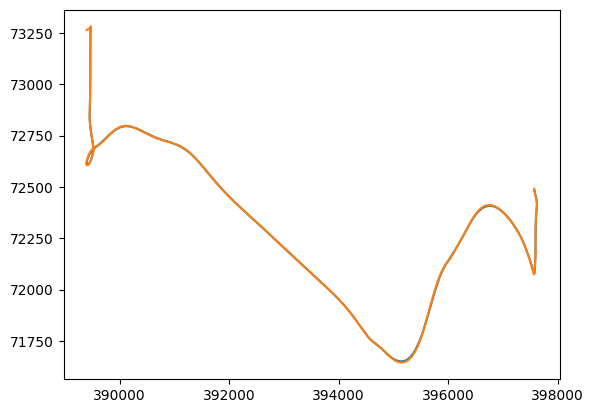

In [26]:
warmup = 50
plt.plot(z[warmup:,0], z[warmup:,1])
plt.plot(np.array(xs)[warmup:,0], np.array(xs)[warmup:,1])

variance = np.diagonal(np.array(ps), axis1=1, axis2=2)
print(variance[-1])